In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import glob
import warnings

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
import graphviz
import shap

file_dir = '/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'

# drop first N hours of data in each wrfstat file
spin_up = 3

In [100]:
features_df, outputs_df = pd.DataFrame(), pd.DataFrame()

# get data capped at height level
lev_i = 6

def get_tminus_df(var, minus_i):
    
    var_df = xr.concat([wrfstat[var][0:minus_i, 0:lev_i]*np.NaN, 
                        wrfstat[var][0:, 0:lev_i]], dim='Time').to_dataframe(var+'_t-'+str(minus_i))
    
    return var_df

for wfile in glob.glob(file_dir+'wrfstat2*')[:2]: 
    
    wrfstat = xr.open_dataset(wfile)

    wrfstat['CSP_WS'] = np.sqrt(wrfstat['CSP_U']**2 + wrfstat['CSP_V']**2)

    time_thres = wrfstat['XTIME'].min().values + np.timedelta64(spin_up, 'h')

    wrfstat = wrfstat.where(wrfstat['XTIME'] >= time_thres, drop=True)
    
    combine_df = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True), 
        [wrfstat['CSP_WS'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_WS', 1), get_tminus_df('CSP_WS', 2),
#          wrfstat['CSP_U'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_U', 1), get_tminus_df('CSP_U', 2),
#          wrfstat['CSP_V'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_V', 1), get_tminus_df('CSP_V', 2),
         wrfstat['CSP_W'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_W', 1), get_tminus_df('CSP_W', 2), 
         wrfstat['CSP_P'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_P', 1), get_tminus_df('CSP_P', 2),
         wrfstat['CSP_THDT_LS'][:, 0:lev_i].to_dataframe(), 
         get_tminus_df('CSP_THDT_LS', 1), get_tminus_df('CSP_THDT_LS', 2),
         wrfstat['CSP_QVDT_LS'][:, 0:lev_i].to_dataframe(), 
         get_tminus_df('CSP_QVDT_LS', 1), get_tminus_df('CSP_QVDT_LS', 2)])
    
    features_df = features_df.append(combine_df.unstack())
    
    outputs_df = outputs_df.append(wrfstat['CSP_WS'][:, 0:lev_i].to_dataframe().unstack())
    
#     with warnings.catch_warnings():
#         warnings.simplefilter(action='ignore', category=FutureWarning)
#         data_df = pd.merge(combine_df.unstack(), 
#                            wrfstat['CSP_WS'][:, lev_i].to_dataframe(), 
#                            left_index=True, right_index=True)
    
features_df.dropna(inplace=True)

new_feacol, new_outcol, hgt_list = [], [], np.empty(0)

for col in features_df.columns.values: 

    new_feacol.append(col[0]+'_'+str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m')

features_df.columns = new_feacol

for col in outputs_df.columns.values: 
    
    lev = int(wrfstat['CSP_Z'][0][col[1]].values)
    new_outcol.append(col[0]+'_'+str(lev)+'m')
    hgt_list = np.append(hgt_list, lev)

outputs_df.columns = new_outcol
hgt_list = np.unique(hgt_list)

# for col in features_df.columns:
# #     print(col)
#     print(str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m')
    
# #     new_col = col[0]+'_'+str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m'
#     new_col = features_df.columns.values[0][0]+'_'+str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m'
    
#     features_df.rename(columns={col: new_col}, inplace=True)

In [117]:
features_df

CSP_WS_15m  CSP_WS_46m  CSP_WS_77m  CSP_WS_108m  CSP_WS_139m  \
Time                                                                 
2       6.422850    7.367338    7.740980     7.913311     7.991522   
3       6.371682    7.310240    7.684707     7.860444     7.943762   
4       6.344862    7.284563    7.662221     7.841904     7.926730   
5       6.293921    7.222752    7.606291     7.799590     7.897383   
6       6.284677    7.215151    7.596813     7.786468     7.880503   
...          ...         ...         ...          ...          ...   
68      0.378251    3.771201    5.013735     5.336427     5.476988   
69      0.329718    3.745493    5.019078     5.346721     5.479195   
70      0.287312    3.721530    5.022686     5.358337     5.483729   
71      0.249638    3.699402    5.023332     5.368172     5.489806   
72      0.217156    3.677494    5.024993     5.375458     5.493010   

      CSP_WS_169m  CSP_WS_t-1_15m  CSP_WS_t-1_46m  CSP_WS_t-1_77m  \
Time                                                                
2        8.030063        6.445815        7.401252        7.784361   
3        7.988800        6.422850        7.367338        7.740980   
4        7.969504        6.371682        7.310240        7.684707   
5        7.949692        6.344862        7.284563        7.662221   
6        7.929264        6.293921        7.222752        7.606291   
...           ...             ...             ...             ...   
68       5.611134        0.432483        3.797231        5.009902   
69       5.608771        0.378251        3.771201        5.013735   
70       5.606841        0.329718        3.745493        5.019078   
71       5.606740        0.287312        3.721530        5.022686   
72       5.606011        0.249638        3.699402        5.023332   

      CSP_WS_t-1_108m  ...  CSP_QVDT_LS_t-1_77m  CSP_QVDT_LS_t-1_108m  \
Time                   ...                                              
2            7.957997  ...         1.130310e-08          1.121132e-08   
3            7.913311  ...         1.099814e-08          1.089717e-08   
4            7.860444  ...         1.070904e-08          1.060967e-08   
5            7.841904  ...         1.042417e-08          1.031674e-08   
6            7.799590  ...         1.013919e-08          1.004326e-08   
...               ...  ...                  ...                   ...   
68           5.328268  ...         3.086067e-09          4.142739e-09   
69           5.336427  ...         3.104123e-09          4.434798e-09   
70           5.346721  ...         3.092537e-09          4.726703e-09   
71           5.358337  ...         3.062472e-09          5.014172e-09   
72           5.368172  ...         3.015497e-09          5.299421e-09   

      CSP_QVDT_LS_t-1_139m  CSP_QVDT_LS_t-1_169m  CSP_QVDT_LS_t-2_15m  \
Time                                                                    
2             1.112331e-08          1.116125e-08         1.129425e-08   
3             1.080089e-08          1.083641e-08         1.095265e-08   
4             1.051671e-08          1.055711e-08         1.066188e-08   
5             1.021194e-08          1.024966e-08         1.037313e-08   
6             9.948780e-09          9.994689e-09         1.008342e-08   
...                    ...                   ...                  ...   
68            4.288009e-09          4.200801e-09         2.783190e-09   
69            4.628949e-09          4.553809e-09         2.789920e-09   
70            4.978189e-09          4.914286e-09         2.794548e-09   
71            5.341089e-09          5.289148e-09         2.799399e-09   
72            5.715145e-09          5.673684e-09         2.797700e-09   

      CSP_QVDT_LS_t-2_46m  CSP_QVDT_LS_t-2_77m  CSP_QVDT_LS_t-2_108m  \
Time                                                                   
2            1.162816e-08         1.165475e-08          1.156977e-08   
3            1.128515e-08         1.130310e-08          1.121132e-08   
4        

In [118]:
hgt_list

array([ 15.,  46.,  77., 108., 139., 169.])

In [ ]:
x_df = features_df.copy(deep=True)


In [122]:
for h in hgt_list:
    print(h >= 77)
    x_df = x_df[x_df.columns[(x_df.columns.str.contains(str(h) == False)]]

False
False
True
True
True
True


In [111]:
features_df.drop(features_df.columns[(features_df.columns.str.contains('77') == True)]]

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (<ipython-input-111-57fed44571de>, line 1)

In [116]:
features_df[features_df.columns[(features_df.columns.str.contains('77') == False)]]

CSP_WS_15m  CSP_WS_46m  CSP_WS_108m  CSP_WS_139m  CSP_WS_169m  \
Time                                                                  
2       6.422850    7.367338     7.913311     7.991522     8.030063   
3       6.371682    7.310240     7.860444     7.943762     7.988800   
4       6.344862    7.284563     7.841904     7.926730     7.969504   
5       6.293921    7.222752     7.799590     7.897383     7.949692   
6       6.284677    7.215151     7.786468     7.880503     7.929264   
...          ...         ...          ...          ...          ...   
68      0.378251    3.771201     5.336427     5.476988     5.611134   
69      0.329718    3.745493     5.346721     5.479195     5.608771   
70      0.287312    3.721530     5.358337     5.483729     5.606841   
71      0.249638    3.699402     5.368172     5.489806     5.606740   
72      0.217156    3.677494     5.375458     5.493010     5.606011   

      CSP_WS_t-1_15m  CSP_WS_t-1_46m  CSP_WS_t-1_108m  CSP_WS_t-1_139m  \
Time                                                                     
2           6.445815        7.401252         7.957997         8.033316   
3           6.422850        7.367338         7.913311         7.991522   
4           6.371682        7.310240         7.860444         7.943762   
5           6.344862        7.284563         7.841904         7.926730   
6           6.293921        7.222752         7.799590         7.897383   
...              ...             ...              ...              ...   
68          0.432483        3.797231         5.328268         5.475078   
69          0.378251        3.771201         5.336427         5.476988   
70          0.329718        3.745493         5.346721         5.479195   
71          0.287312        3.721530         5.358337         5.483729   
72          0.249638        3.699402         5.368172         5.489806   

      CSP_WS_t-1_169m  ...  CSP_QVDT_LS_t-1_15m  CSP_QVDT_LS_t-1_46m  \
Time                   ...                                             
2            8.068511  ...         1.095265e-08         1.128515e-08   
3            8.030063  ...         1.066188e-08         1.099166e-08   
4            7.988800  ...         1.037313e-08         1.070588e-08   
5            7.969504  ...         1.008342e-08         1.042245e-08   
6            7.949692  ...         9.792672e-09         1.013391e-08   
...               ...  ...                  ...                  ...   
68           5.611993  ...         2.789920e-09         1.644518e-09   
69           5.611134  ...         2.794548e-09         1.372111e-09   
70           5.608771  ...         2.799399e-09         1.076254e-09   
71           5.606841  ...         2.797700e-09         7.625587e-10   
72           5.606740  ...         2.786004e-09         4.255488e-10   

      CSP_QVDT_LS_t-1_108m  CSP_QVDT_LS_t-1_139m  CSP_QVDT_LS_t-1_169m  \
Time                                                                     
2             1.121132e-08          1.112331e-08          1.116125e-08   
3             1.089717e-08          1.080089e-08          1.083641e-08   
4             1.060967e-08          1.051671e-08          1.055711e-08   
5             1.031674e-08          1.021194e-08          1.024966e-08   
6             1.004326e-08          9.948780e-09          9.994689e-09   
...                    ...                   ...                   ...   
68            4.142739e-09          4.288009e-09          4.200801e-09   
69            4.434798e-09          4.628949e-09          4.553809e-09   
70            4.726703e-09          4.978189e-09          4.914286e-09   
71            5.014172e-09          5.341089e-09          5.289148e-09   
72            5.299421e-09          5.715145e-09          5.673684e-09   

      CSP_QVDT_LS_t-2_15m  CSP_QVDT_LS_t-2_46m  CSP_QVDT_LS_t-2_108m  \
Time                                                                   
2            1.129425e-08         1.162816e-08          1.156977e-08   
3  

In [94]:
outputs_df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            63, 64, 65, 66, 67, 68, 69, 70, 71, 72],
           dtype='int64', name='Time', length=146)

In [82]:
wrfstat['CSP_WS'][:, 0:lev_i].to_dataframe().unstack()

CSP_WS                              
bottom_top         0         1         2         3
Time                                              
0           6.050071  6.902952  7.245491  7.440013
1           6.282769  7.176702  7.521436  7.698711
2           6.507604  7.450828  7.815089  7.989653
3           6.720558  7.705202  8.076726  8.244323
4           6.871342  7.892187  8.279087  8.448408
...              ...       ...       ...       ...
68          0.378251  3.771201  5.013735  5.336427
69          0.329718  3.745493  5.019078  5.346721
70          0.287312  3.721530  5.022686  5.358337
71          0.249638  3.699402  5.023332  5.368172
72          0.217156  3.677494  5.024993  5.375458

[73 rows x 4 columns]

In [55]:
features_df.shape

(142, 72)

In [59]:
lst = ['h'] * 72
lst

['h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h']

In [60]:
features_df.columns = lst

In [61]:
features_df

h         h         h         h         h         h         h  \
Time                                                                         
2     2.699251  3.095296  3.239418  3.301907  2.621955  3.014753  3.163542   
3     2.764522  3.172666  3.322327  3.386163  2.699251  3.095296  3.239418   
4     2.821296  3.240194  3.400702  3.473794  2.764522  3.172666  3.322327   
5     2.865080  3.295971  3.471529  3.558311  2.821296  3.240194  3.400702   
6     2.935016  3.373641  3.547235  3.629505  2.865080  3.295971  3.471529   
...        ...       ...       ...       ...       ...       ...       ...   
68    0.216412  2.163026  2.870683  3.052341  0.247852  2.178167  2.868459   
69    0.188713  2.148252  2.873692  3.057789  0.216412  2.163026  2.870683   
70    0.164726  2.134684  2.876243  3.064552  0.188713  2.148252  2.873692   
71    0.142930  2.121714  2.878266  3.071330  0.164726  2.134684  2.876243   
72    0.124498  2.109812  2.880201  3.075981  0.142930  2.121714  2.878266   

             h         h         h  ...             h             h  \
Time                                ...                               
2     3.226890  2.547931  2.929942  ...  1.099814e-08  1.089717e-08   
3     3.301907  2.621955  3.014753  ...  1.070904e-08  1.060967e-08   
4     3.386163  2.699251  3.095296  ...  1.042417e-08  1.031674e-08   
5     3.473794  2.764522  3.172666  ...  1.013919e-08  1.004326e-08   
6     3.558311  2.821296  3.240194  ...  9.842393e-09  9.742739e-09   
...        ...       ...       ...  ...           ...           ...   
68    3.047448  0.283055  2.194406  ...  3.104123e-09  4.434798e-09   
69    3.052341  0.247852  2.178167  ...  3.092537e-09  4.726703e-09   
70    3.057789  0.216412  2.163026  ...  3.062472e-09  5.014172e-09   
71    3.064552  0.188713  2.148252  ...  3.015497e-09  5.299421e-09   
72    3.071330  0.164726  2.134684  ...  2.943209e-09  5.579151e-09   

                 h             h             h             h             h  \
Time                                                                         
2     1.095265e-08  1.128515e-08  1.130310e-08  1.121132e-08  1.129425e-08   
3     1.066188e-08  1.099166e-08  1.099814e-08  1.089717e-08  1.095265e-08   
4     1.037313e-08  1.070588e-08  1.070904e-08  1.060967e-08  1.066188e-08   
5     1.008342e-08  1.042245e-08  1.042417e-08  1.031674e-08  1.037313e-08   
6     9.792672e-09  1.013391e-08  1.013919e-08  1.004326e-08  1.008342e-08   
...            ...           ...           ...           ...           ...   
68    2.789920e-09  1.644518e-09  3.086067e-09  4.142739e-09  2.783190e-09   
69    2.794548e-09  1.372111e-09  3.104123e-09  4.434798e-09  2.789920e-09   
70    2.799399e-09  1.076254e-09  3.092537e-09  4.726703e-09  2.794548e-09   
71    2.797700e-09  7.625587e-10  3.062472e-09  5.014172e-09  2.799399e-09   
72    2.786004e-09  4.255488e-10  3.015497e-09  5.299421e-09  2.797700e-09   

                 h             h             h  
Time                                            
2     1.162816e-08  1.165475e-08  1.156977e-08  
3     1.128515e-08  1.130310e-08  1.121132e-08  
4     1.099166e-08  1.099814e-08  1.089717e-08  
5     1.070588e-08  1.070904e-08  1.060967e-08  
6     1.042245e-08  1.042417e-08  1.031674e-08  
...            ...           ...           ...  
68    1.809420e-09  3.081481e-09  3.962712e-09  
69    1.644518e-09  3.086067e-09  4.142739e-09  
70    1.372111e-09  3.104123e-09  4.434798e-09  
71    1.076254e-09  3.092537e-09  4.726703e-09  
72    7.625587e-10  3.062472e-09  5.014172e-09  

[142 rows x 72 columns]

In [36]:
features_df.columns.get_level_values(0)[0]+features_df.columns.get_level_values(1)[0]

'CSP_U'

In [35]:
features_df.columns.get_level_values(1)

Int64Index([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
            2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
            0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
            2, 3, 0, 1, 2, 3],
           dtype='int64', name='bottom_top')

In [37]:
features_df.columns.map('_'.join)

TypeError: sequence item 1: expected str instance, int found

In [67]:
new_col = []
for col in features_df.columns.values: 
    
    new_col.append(col[0]+'_'+str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m')
new_col

['CSP_U_15m',
 'CSP_U_46m',
 'CSP_U_77m',
 'CSP_U_108m',
 'CSP_U_t-1_15m',
 'CSP_U_t-1_46m',
 'CSP_U_t-1_77m',
 'CSP_U_t-1_108m',
 'CSP_U_t-2_15m',
 'CSP_U_t-2_46m',
 'CSP_U_t-2_77m',
 'CSP_U_t-2_108m',
 'CSP_V_15m',
 'CSP_V_46m',
 'CSP_V_77m',
 'CSP_V_108m',
 'CSP_V_t-1_15m',
 'CSP_V_t-1_46m',
 'CSP_V_t-1_77m',
 'CSP_V_t-1_108m',
 'CSP_V_t-2_15m',
 'CSP_V_t-2_46m',
 'CSP_V_t-2_77m',
 'CSP_V_t-2_108m',
 'CSP_W_15m',
 'CSP_W_46m',
 'CSP_W_77m',
 'CSP_W_108m',
 'CSP_W_t-1_15m',
 'CSP_W_t-1_46m',
 'CSP_W_t-1_77m',
 'CSP_W_t-1_108m',
 'CSP_W_t-2_15m',
 'CSP_W_t-2_46m',
 'CSP_W_t-2_77m',
 'CSP_W_t-2_108m',
 'CSP_P_15m',
 'CSP_P_46m',
 'CSP_P_77m',
 'CSP_P_108m',
 'CSP_P_t-1_15m',
 'CSP_P_t-1_46m',
 'CSP_P_t-1_77m',
 'CSP_P_t-1_108m',
 'CSP_P_t-2_15m',
 'CSP_P_t-2_46m',
 'CSP_P_t-2_77m',
 'CSP_P_t-2_108m',
 'CSP_THDT_LS_15m',
 'CSP_THDT_LS_46m',
 'CSP_THDT_LS_77m',
 'CSP_THDT_LS_108m',
 'CSP_THDT_LS_t-1_15m',
 'CSP_THDT_LS_t-1_46m',
 'CSP_THDT_LS_t-1_77m',
 'CSP_THDT_LS_t-1_108m',
 'CSP_THDT

In [44]:
str(features_df.columns.values[0][1])

'0'

In [24]:
[''.join(col).strip() for col in features_df.columns.values]

TypeError: sequence item 1: expected str instance, int found

In [43]:
features_df.columns.values[0][0], str(features_df.columns.values[0][1])

('CSP_U', '0')

In [3]:
wrfstat

<xarray.Dataset>
Dimensions:      (Time: 73, bottom_top: 16)
Dimensions without coordinates: Time, bottom_top
Data variables: (12/32)
    CSP_Z        (Time, bottom_top) float32 15.71 47.0 78.05 ... 448.7 479.5
    CSP_U        (Time, bottom_top) float32 0.9119 1.031 1.071 ... 2.101 2.101
    CSP_V        (Time, bottom_top) float32 5.272 5.963 6.242 ... 3.696 3.698
    CSP_P        (Time, bottom_top) float32 9.778e+04 9.743e+04 ... 9.278e+04
    CSP_THV      (Time, bottom_top) float32 303.3 303.0 302.9 ... 305.9 305.9
    CSP_TH       (Time, bottom_top) float32 300.7 300.5 300.4 ... 303.8 303.8
    ...           ...
    CST_PRECT    (Time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CST_CLDTOT   (Time) float32 0.1475 0.2537 0.3005 0.2926 ... 0.0 0.0 0.0 0.0
    CST_LWP      (Time) float32 0.003624 0.007901 0.01039 ... 0.0 0.0 0.0
    XTIME        (Time) datetime64[ns] 2018-05-22T15:00:00 ... 2018-05-23T03:...
    Times        (Time) object b'2018-05-22_15:00:00' ... b'2018-05-23_03:00:00'
    CSP_WS       (Time, bottom_top) float32 5.35 6.051 6.333 ... 4.252 4.253
Attributes: (12/97)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2018-05-22_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20180522v1var
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

In [7]:
wrfstat['CSP_Z'][0].values

array([ 15.71343 ,  47.004936,  78.053444, 108.9032  , 139.648   ,
       170.38089 , 201.08194 , 231.7308  , 262.35602 , 292.9693  ,
       323.57123 , 354.16388 , 384.74677 , 415.31918 , 445.8851  ,
       476.4479  ], dtype=float32)

In [11]:
out_df

CSP_U_15m  CSP_U_46m  CSP_U_77m  CSP_U_108m  CSP_U_t-1_15m  \
Time                                                               
2      2.699251   3.095296   3.239418    3.301907       2.621955   
3      2.764522   3.172666   3.322327    3.386163       2.699251   
4      2.821296   3.240194   3.400702    3.473794       2.764522   
5      2.865080   3.295971   3.471529    3.558311       2.821296   
6      2.935016   3.373641   3.547235    3.629505       2.865080   
...         ...        ...        ...         ...            ...   
68     0.216412   2.163026   2.870683    3.052341       0.247852   
69     0.188713   2.148252   2.873692    3.057789       0.216412   
70     0.164726   2.134684   2.876243    3.064552       0.188713   
71     0.142930   2.121714   2.878266    3.071330       0.164726   
72     0.124498   2.109812   2.880201    3.075981       0.142930   

      CSP_U_t-1_46m  CSP_U_t-1_77m  CSP_U_t-1_108m  CSP_U_t-2_15m  \
Time                                                                
2          3.014753       3.163542        3.226890       2.547931   
3          3.095296       3.239418        3.301907       2.621955   
4          3.172666       3.322327        3.386163       2.699251   
5          3.240194       3.400702        3.473794       2.764522   
6          3.295971       3.471529        3.558311       2.821296   
...             ...            ...             ...            ...   
68         2.178167       2.868459        3.047448       0.283055   
69         2.163026       2.870683        3.052341       0.247852   
70         2.148252       2.873692        3.057789       0.216412   
71         2.134684       2.876243        3.064552       0.188713   
72         2.121714       2.878266        3.071330       0.164726   

      CSP_U_t-2_46m  ...  CSP_QVDT_LS_108m  CSP_QVDT_LS_t-1_15m  \
Time                 ...                                          
2          2.929942  ...      1.089717e-08         1.095265e-08   
3          3.014753  ...      1.060967e-08         1.066188e-08   
4          3.095296  ...      1.031674e-08         1.037313e-08   
5          3.172666  ...      1.004326e-08         1.008342e-08   
6          3.240194  ...      9.742739e-09         9.792672e-09   
...             ...  ...               ...                  ...   
68         2.194406  ...      4.434798e-09         2.789920e-09   
69         2.178167  ...      4.726703e-09         2.794548e-09   
70         2.163026  ...      5.014172e-09         2.799399e-09   
71         2.148252  ...      5.299421e-09         2.797700e-09   
72         2.134684  ...      5.579151e-09         2.786004e-09   

      CSP_QVDT_LS_t-1_46m  CSP_QVDT_LS_t-1_77m  CSP_QVDT_LS_t-1_108m  \
Time                                                                   
2            1.128515e-08         1.130310e-08          1.121132e-08   
3            1.099166e-08         1.099814e-08          1.089717e-08   
4            1.070588e-08         1.070904e-08          1.060967e-08   
5            1.042245e-08         1.042417e-08          1.031674e-08   
6            1.013391e-08         1.013919e-08          1.004326e-08   
...                   ...                  ...                   ...   
68           1.644518e-09         3.086067e-09          4.142739e-09   
69           1.372111e-09         3.104123e-09          4.434798e-09   
70           1.076254e-09         3.092537e-09          4.726703e-09   
71           7.625587e-10         3.062472e-09          5.014172e-09   
72           4.255488e-10         3.015497e-09          5.299421e-09   

      CSP_QVDT_LS_t-2_15m  CSP_QVDT_LS_t-2_46m  CSP_QVDT_LS_t-2_77m  \
Time                                                                  
2            1.129425e-08         1.162816e-08         1.165475e-08   
3            1.095265e-08         1.128515e-08         1.130310e-08   
4            1.066188e-08         1.099166e-08         1.099814e-08   
5            1.037313e-08         1.070588e-08         1.07

In [5]:
X = out_df.drop(['CSP_WS'], axis=1)
y = out_df['CSP_WS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
print(X_train.shape, X_test.shape)

## XGBoost

In [7]:
regressor = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=4,
    subsample=0.8,
)

regressor.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=UserWarning)
    y_pred = regressor.predict(X_test)
    
print(mean_squared_error(y_test, y_pred))

0.02225133


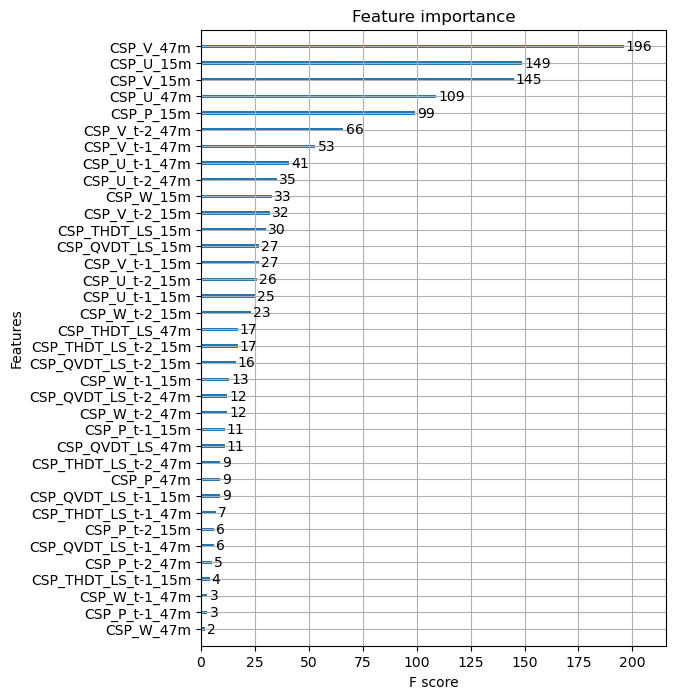

In [8]:
fig, ax = plt.subplots(figsize=(6, 8))
xgb.plot_importance(regressor, ax=ax)
plt.show()

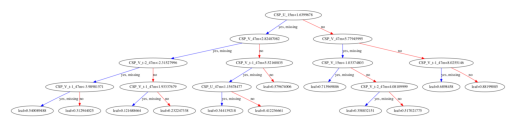

In [9]:
# need to install graphviz on conda (Python) and brew (system)
xgb.plot_tree(regressor, num_trees=1)
plt.show()

In [59]:
regressor = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [2, 5, 10],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.6, 0.7, 0.8]
}

# Fitting 10 folds for each of 1458 candidates, totalling 14580 fits
# Best: -0.013091 using {'colsample_bytree': 0.7, 'learning_rate': 0.1, 
#                        'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 1.2, 
#                        'reg_lambda': 1.3, 'subsample': 0.8}

grid_search = GridSearchCV(regressor, param_grid, 
                           scoring='neg_mean_squared_error', n_jobs=-1, cv=10, verbose=2)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits
Best: -0.013091 using {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 1.2, 'reg_lambda': 1.3, 'subsample': 0.8}
-4.467926 (0.469339) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.6}
-4.457242 (0.472684) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.7}
-4.448175 (0.461980) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.8}
-4.473180 (0.470229) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.2, 'subsample': 0.6}
-4.462707 (0.473925) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_esti

## Random forest

In [10]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
#     bootstrap=True
)

rf.fit(X_train, y_train)

# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=UserWarning)
y_pred = rf.predict(X_test)

print(mean_squared_error(y_test, y_pred))

0.4258912060570084


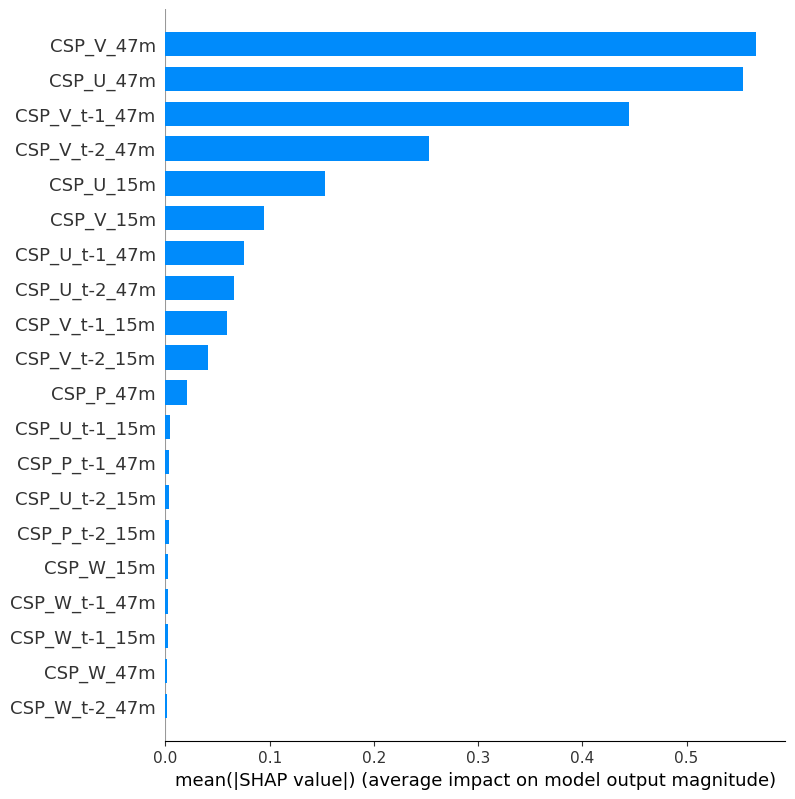

In [11]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

In [198]:
rf = RandomForestRegressor()

param_dist = {'max_depth': [3, None],
              'max_features': sp_randint(1, X_train.shape[1]),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap': [True, False],
              'n_estimators': sp_randint(100, 500)}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, 
                                   n_iter=10, cv=10, random_state=42)
random_search.fit(X_train, y_train)
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Best: -0.013253 using {'bootstrap': False, 'max_depth': None, 'max_features': 21, 'min_samples_split': 2, 'n_estimators': 413}


## Power law

In [136]:
x_df = X_test.copy(deep=True)

u_col = x_df.columns[(x_df.columns.str.contains('CSP_U') == True) & (x_df.columns.str.contains('-') == False)]

lev_list = np.empty(0)

for u_lev in u_col: 
    
    lev = u_lev.split('_')[-1].replace('m', '')
    v_lev = X_test.columns[(X_test.columns.str.contains('CSP_V') == True) 
                           & (X_test.columns.str.contains(lev) == True) 
                           & (X_test.columns.str.contains('-') == False)]

    x_df['CSP_WS_'+lev+'m'] = np.sqrt(X_test[u_lev]**2 + X_test[v_lev].iloc[:, 0]**2)

    lev_list = np.append(lev_list, float(lev))
    
target_hgt = wrfstat['CSP_Z'][0, lev_i].values

if (target_hgt < lev_list).sum() == 0: 
    
    levs = np.sort(lev_list)[-2:]
    
    alpha = np.log(x_df['CSP_WS_'+str(int(levs[1]))+'m']/x_df['CSP_WS_'+str(int(levs[0]))+'m'])\
            /np.log(levs[1]/levs[0])
    
    x_df['CSP_WS_'+str(int(target_hgt))+'m'] = x_df['CSP_WS_'+str(int(levs[1]))+'m']*(target_hgt/levs[1])**alpha
    
print(mean_squared_error(y_test, x_df['CSP_WS_'+str(int(target_hgt))+'m']))

0.80492806


In [137]:
x_df

CSP_U_15m  CSP_U_47m  CSP_U_t-1_15m  CSP_U_t-1_47m  CSP_U_t-2_15m  \
Time                                                                      
16     2.759368   3.226943       2.772498       3.241255       2.801765   
14    -2.491554  -2.776735      -2.488374      -2.772833      -2.487083   
24     3.458544   3.992806       3.503297       4.047067       3.510150   
18    -0.556138  -0.616339      -0.569252      -0.626987      -0.545107   
46    -0.716941  -0.823238      -0.722952      -0.829531      -0.701325   
...         ...        ...            ...            ...            ...   
38    -3.413802  -3.962205      -3.455351      -4.000852      -3.482075   
52    -0.406128  -0.470133      -0.409657      -0.472719      -0.400982   
26     2.583134   2.962316       2.753967       3.168886       2.914855   
56     0.244198   0.283589       0.245385       0.288759       0.250356   
48     2.776186   3.217068       2.788810       3.231533       2.804683   

      CSP_U_t-2_47m  CSP_V_15m  CSP_V_47m  CSP_V_t-1_15m  CSP_V_t-1_47m  ...  \
Time                                                                     ...   
16         3.275296   8.593307  10.003632       8.672577      10.100615  ...   
14        -2.769011  -0.310252  -0.345264      -0.281344      -0.313217  ...   
24         4.056444   4.885180   5.644583       4.940576       5.712675  ...   
18        -0.604844   1.298139   1.436531       1.381173       1.528219  ...   
46        -0.806462   4.021403   4.614149       4.076398       4.671782  ...   
...             ...        ...        ...            ...            ...  ...   
38        -4.028667  -3.534173  -4.096078      -3.553500      -4.120073  ...   
52        -0.463745   4.077456   4.746090       4.120335       4.787053  ...   
26         3.352592   5.298970   6.090140       5.434222       6.240026  ...   
56         0.288096   2.456484   2.860643       2.479193       2.871705  ...   
48         3.240879   3.076730   3.557772       3.088365       3.571660  ...   

      CSP_THDT_LS_t-2_47m  CSP_QVDT_LS_15m  CSP_QVDT_LS_47m  \
Time                                                          
16          -2.445863e-05     3.162013e-08     3.193158e-08   
14          -4.685420e-05    -8.175148e-10    -1.123881e-09   
24           8.536132e-06    -2.966156e-09    -4.172583e-09   
18          -8.477947e-08     4.464969e-09     4.535210e-09   
46          -9.672311e-05     1.008884e-08     9.510554e-09   
...                   ...              ...              ...   
38           6.373582e-06     4.083728e-09     4.233459e-09   
52          -5.729086e-05     1.523567e-08     1.479055e-08   
26          -8.730543e-06     5.955330e-09     6.258582e-09   
56          -8.625812e-05     2.818184e-08     2.740779e-08   
48          -6.125662e-05    -1.639653e-08    -1.662163e-08   

      CSP_QVDT_LS_t-1_15m  CSP_QVDT_LS_t-1_47m  CSP_QVDT_LS_t-2_15m  \
Time                                                                  
16           3.350019e-08         3.382171e-08         3.538492e-08   
14          -4.872155e-10        -7.814772e-10        -4.238390e-10   
24          -4.573742e-09        -5.896511e-09        -6.179522e-09   
18           4.126628e-09         4.133987e-09         3.788372e-09   
46           1.202787e-08         1.149185e-08         1.396393e-08   
...                   ...                  ...                  ...   
38           3.447512e-09         3.560312e-09         2.994133e-09   
52           1.495529e-08         1.450476e-08         1.467294e-08   
26           7.754921e-09         8.118765e-09         9.711043e-09   
56           3.160666e-08         3.083041e-08         3.418008e-08   
48          -1.666541e-08        -1.690536e-08        -1.693298e-08   

      CSP_QVDT_LS_t-2_47m  CSP_WS_15m  CSP_WS_47m  CSP_WS_78m  
Time                                                           
16           3.571675e-08    9.025466   10.511223   11.247286  
14          -6.951743e-10    2.510797    2.798118    

In [ ]:
x_df['CSP_WS_'+str(int(target_hgt))+'m'], y_test

In [133]:
print(mean_squared_error(y_test, x_df['CSP_WS_'+str(int(target_hgt))+'m']))

0.80492806


In [111]:
lev_list = np.sort(lev_list)

array([15., 47.])

In [109]:
lev_list

array([15., 47.])

In [110]:
type(lev_list)

numpy.ndarray

In [127]:
target_hgt = wrfstat['CSP_Z'][0, lev_i].values

if (target_hgt < lev_list).sum() == 0: 
    
    levs = np.sort(lev_list)[-2:]
    print(levs)
    
    levs[0]
    
    alpha = np.log(x_df['CSP_WS_'+str(int(levs[1]))+'m']/x_df['CSP_WS_'+str(int(levs[0]))+'m'])\
            /np.log(levs[1]/levs[0])
    print(alpha)
    
    x_df['CSP_WS_'+str(int(target_hgt))+'m'] = x_df['CSP_WS_'+str(int(levs[1]))+'m']*(target_hgt/levs[1])**alpha

[15. 47.]
Time
16    0.133433
14    0.094867
24    0.126266
18    0.088897
46    0.120410
        ...   
38    0.129795
52    0.132908
26    0.121477
56    0.133341
48    0.128029
Length: 1307, dtype: float32


In [128]:
x_df

CSP_U_15m  CSP_U_47m  CSP_U_t-1_15m  CSP_U_t-1_47m  CSP_U_t-2_15m  \
Time                                                                      
16     2.759368   3.226943       2.772498       3.241255       2.801765   
14    -2.491554  -2.776735      -2.488374      -2.772833      -2.487083   
24     3.458544   3.992806       3.503297       4.047067       3.510150   
18    -0.556138  -0.616339      -0.569252      -0.626987      -0.545107   
46    -0.716941  -0.823238      -0.722952      -0.829531      -0.701325   
...         ...        ...            ...            ...            ...   
38    -3.413802  -3.962205      -3.455351      -4.000852      -3.482075   
52    -0.406128  -0.470133      -0.409657      -0.472719      -0.400982   
26     2.583134   2.962316       2.753967       3.168886       2.914855   
56     0.244198   0.283589       0.245385       0.288759       0.250356   
48     2.776186   3.217068       2.788810       3.231533       2.804683   

      CSP_U_t-2_47m  CSP_V_15m  CSP_V_47m  CSP_V_t-1_15m  CSP_V_t-1_47m  ...  \
Time                                                                     ...   
16         3.275296   8.593307  10.003632       8.672577      10.100615  ...   
14        -2.769011  -0.310252  -0.345264      -0.281344      -0.313217  ...   
24         4.056444   4.885180   5.644583       4.940576       5.712675  ...   
18        -0.604844   1.298139   1.436531       1.381173       1.528219  ...   
46        -0.806462   4.021403   4.614149       4.076398       4.671782  ...   
...             ...        ...        ...            ...            ...  ...   
38        -4.028667  -3.534173  -4.096078      -3.553500      -4.120073  ...   
52        -0.463745   4.077456   4.746090       4.120335       4.787053  ...   
26         3.352592   5.298970   6.090140       5.434222       6.240026  ...   
56         0.288096   2.456484   2.860643       2.479193       2.871705  ...   
48         3.240879   3.076730   3.557772       3.088365       3.571660  ...   

      CSP_THDT_LS_t-2_47m  CSP_QVDT_LS_15m  CSP_QVDT_LS_47m  \
Time                                                          
16          -2.445863e-05     3.162013e-08     3.193158e-08   
14          -4.685420e-05    -8.175148e-10    -1.123881e-09   
24           8.536132e-06    -2.966156e-09    -4.172583e-09   
18          -8.477947e-08     4.464969e-09     4.535210e-09   
46          -9.672311e-05     1.008884e-08     9.510554e-09   
...                   ...              ...              ...   
38           6.373582e-06     4.083728e-09     4.233459e-09   
52          -5.729086e-05     1.523567e-08     1.479055e-08   
26          -8.730543e-06     5.955330e-09     6.258582e-09   
56          -8.625812e-05     2.818184e-08     2.740779e-08   
48          -6.125662e-05    -1.639653e-08    -1.662163e-08   

      CSP_QVDT_LS_t-1_15m  CSP_QVDT_LS_t-1_47m  CSP_QVDT_LS_t-2_15m  \
Time                                                                  
16           3.350019e-08         3.382171e-08         3.538492e-08   
14          -4.872155e-10        -7.814772e-10        -4.238390e-10   
24          -4.573742e-09        -5.896511e-09        -6.179522e-09   
18           4.126628e-09         4.133987e-09         3.788372e-09   
46           1.202787e-08         1.149185e-08         1.396393e-08   
...                   ...                  ...                  ...   
38           3.447512e-09         3.560312e-09         2.994133e-09   
52           1.495529e-08         1.450476e-08         1.467294e-08   
26           7.754921e-09         8.118765e-09         9.711043e-09   
56           3.160666e-08         3.083041e-08         3.418008e-08   
48          -1.666541e-08        -1.690536e-08        -1.693298e-08   

      CSP_QVDT_LS_t-2_47m  CSP_WS_15m  CSP_WS_47m  CSP_WS_78m  
Time                                                           
16           3.571675e-08    9.025466   10.511223   11.247286  
14          -6.951743e-10    2.510797    2.798118    

In [26]:
u_col = x_df.columns[(x_df.columns.str.contains('CSP_U')==True) & (x_df.columns.str.contains('-')==False)]
u_col

Index(['CSP_U_15m', 'CSP_U_47m'], dtype='object')

In [33]:
float(u_col[0].split('_')[-1].replace('m', ''))

15.0

In [73]:
for u_lev in u_col: 
    lev = u_lev.split('_')[-1].replace('m', '')
    v_lev = X_test.columns[(X_test.columns.str.contains('CSP_V')==True) 
                           & (X_test.columns.str.contains(lev)==True) & (X_test.columns.str.contains('-')==False)]
#     print(u_lev, v_lev)
    x_df['CSP_WS_'+lev+'m'] = np.sqrt(X_test[u_lev]**2 + X_test[v_lev].iloc[:, 0]**2)

CSP_U_15m Index(['CSP_V_15m'], dtype='object')
CSP_U_47m Index(['CSP_V_47m'], dtype='object')


In [74]:
x_df

CSP_U_15m  CSP_U_47m  CSP_U_t-1_15m  CSP_U_t-1_47m  CSP_U_t-2_15m  \
Time                                                                      
16     2.759368   3.226943       2.772498       3.241255       2.801765   
14    -2.491554  -2.776735      -2.488374      -2.772833      -2.487083   
24     3.458544   3.992806       3.503297       4.047067       3.510150   
18    -0.556138  -0.616339      -0.569252      -0.626987      -0.545107   
46    -0.716941  -0.823238      -0.722952      -0.829531      -0.701325   
...         ...        ...            ...            ...            ...   
38    -3.413802  -3.962205      -3.455351      -4.000852      -3.482075   
52    -0.406128  -0.470133      -0.409657      -0.472719      -0.400982   
26     2.583134   2.962316       2.753967       3.168886       2.914855   
56     0.244198   0.283589       0.245385       0.288759       0.250356   
48     2.776186   3.217068       2.788810       3.231533       2.804683   

      CSP_U_t-2_47m  CSP_V_15m  CSP_V_47m  CSP_V_t-1_15m  CSP_V_t-1_47m  ...  \
Time                                                                     ...   
16         3.275296   8.593307  10.003632       8.672577      10.100615  ...   
14        -2.769011  -0.310252  -0.345264      -0.281344      -0.313217  ...   
24         4.056444   4.885180   5.644583       4.940576       5.712675  ...   
18        -0.604844   1.298139   1.436531       1.381173       1.528219  ...   
46        -0.806462   4.021403   4.614149       4.076398       4.671782  ...   
...             ...        ...        ...            ...            ...  ...   
38        -4.028667  -3.534173  -4.096078      -3.553500      -4.120073  ...   
52        -0.463745   4.077456   4.746090       4.120335       4.787053  ...   
26         3.352592   5.298970   6.090140       5.434222       6.240026  ...   
56         0.288096   2.456484   2.860643       2.479193       2.871705  ...   
48         3.240879   3.076730   3.557772       3.088365       3.571660  ...   

      CSP_THDT_LS_t-2_15m  CSP_THDT_LS_t-2_47m  CSP_QVDT_LS_15m  \
Time                                                              
16          -2.498619e-05        -2.445863e-05     3.162013e-08   
14          -4.636313e-05        -4.685420e-05    -8.175148e-10   
24           1.089306e-05         8.536132e-06    -2.966156e-09   
18           1.991918e-07        -8.477947e-08     4.464969e-09   
46          -9.608374e-05        -9.672311e-05     1.008884e-08   
...                   ...                  ...              ...   
38           6.298319e-06         6.373582e-06     4.083728e-09   
52          -5.683990e-05        -5.729086e-05     1.523567e-08   
26          -9.543228e-06        -8.730543e-06     5.955330e-09   
56          -8.575855e-05        -8.625812e-05     2.818184e-08   
48          -6.102278e-05        -6.125662e-05    -1.639653e-08   

      CSP_QVDT_LS_47m  CSP_QVDT_LS_t-1_15m  CSP_QVDT_LS_t-1_47m  \
Time                                                              
16       3.193158e-08         3.350019e-08         3.382171e-08   
14      -1.123881e-09        -4.872155e-10        -7.814772e-10   
24      -4.172583e-09        -4.573742e-09        -5.896511e-09   
18       4.535210e-09         4.126628e-09         4.133987e-09   
46       9.510554e-09         1.202787e-08         1.149185e-08   
...               ...                  ...                  ...   
38       4.233459e-09         3.447512e-09         3.560312e-09   
52       1.479055e-08         1.495529e-08         1.450476e-08   
26       6.258582e-09         7.754921e-09         8.118765e-09   
56       2.740779e-08         3.160666e-08         3.083041e-08   
48      -1.662163e-08        -1.666541e-08        -1.690536e-08   

      CSP_QVDT_LS_t-2_15m  CSP_QVDT_LS_t-2_47m  CSP_WS_15m  CSP_WS_47m  
Time                                                                    
16           3.538492e-08         3.571675e-08    9.025466   10.511223  
14          -4.238390e-10 

In [50]:
X_test[u_lev]**2

Time
16    10.413158
14     7.710259
24    15.942499
18     0.379874
46     0.677721
        ...    
38    15.699070
52     0.221025
26     8.775318
56     0.080423
48    10.349527
Name: CSP_U_47m, Length: 1307, dtype: float32

In [69]:
np.sqrt(X_test[u_lev]**2 + X_test[v_lev].iloc[:, 0]**2)

Time
16    10.511223
14     2.798118
24     6.914030
18     1.563168
46     4.687013
        ...    
38     5.698853
52     4.769319
26     6.772380
56     2.874666
48     4.796589
Length: 1307, dtype: float32

In [38]:
wrfstat['CSP_Z'][0, lev_i].values

array(78.053444, dtype=float32)

## Examine wrfstat files

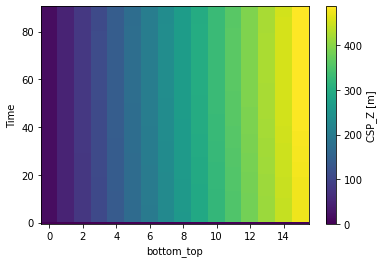

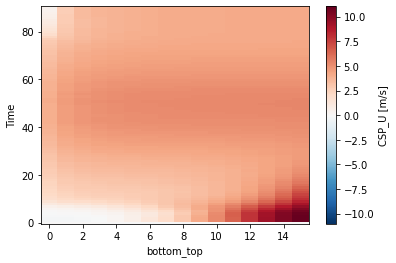

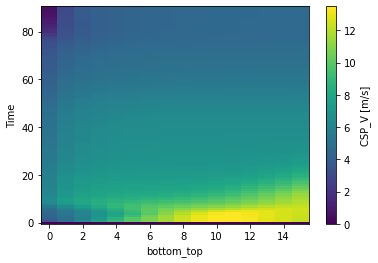

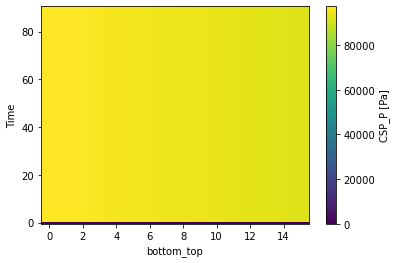

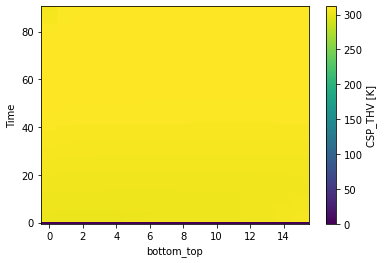

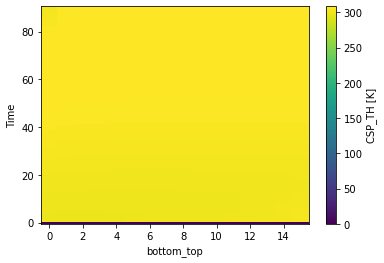

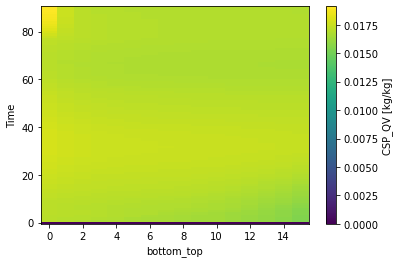

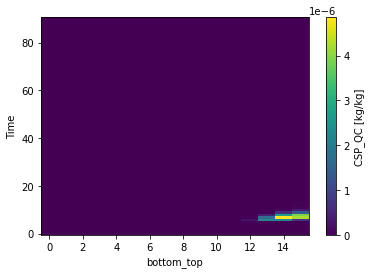

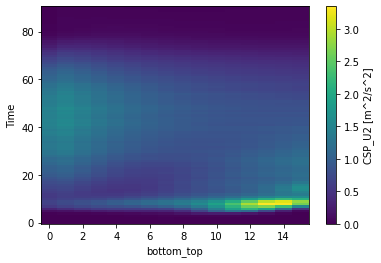

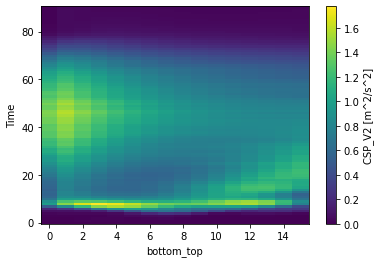

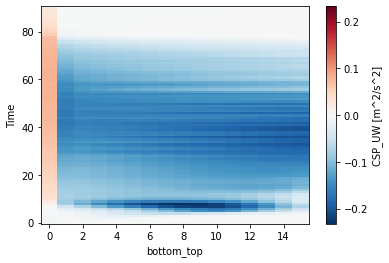

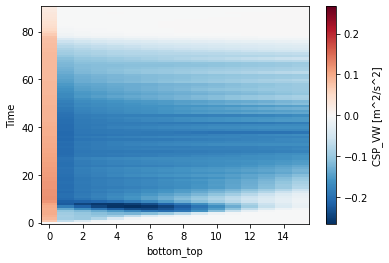

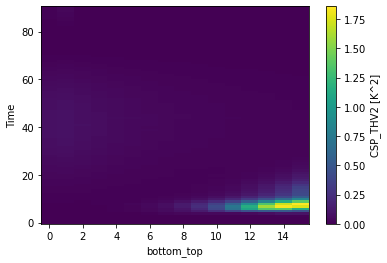

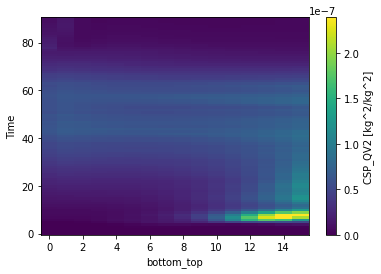

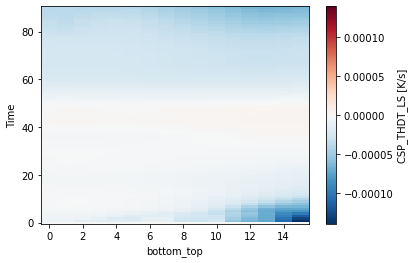

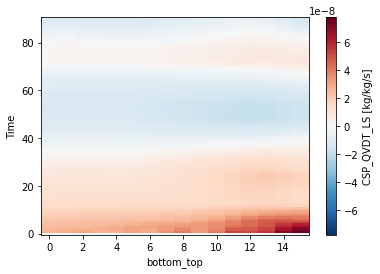

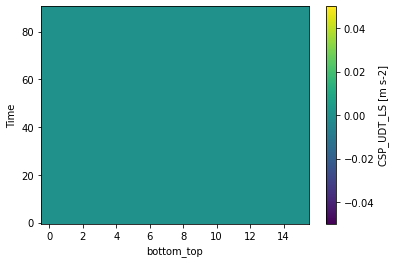

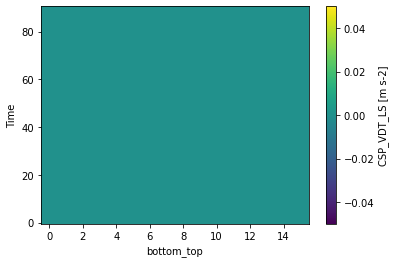

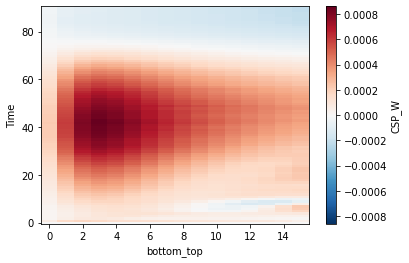

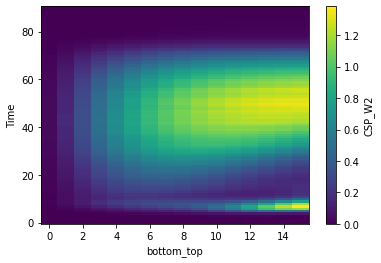

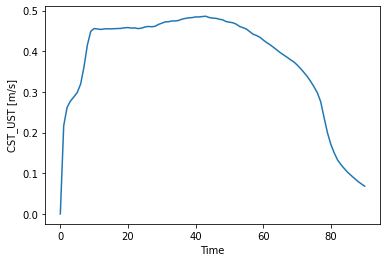

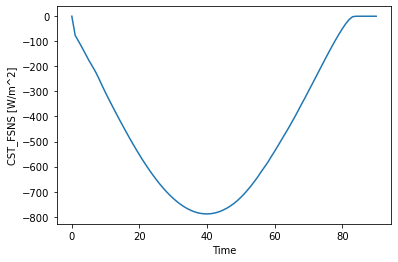

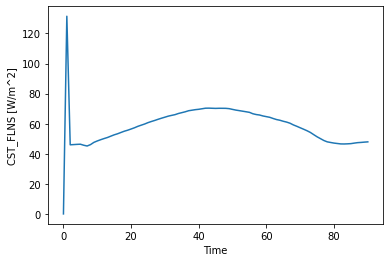

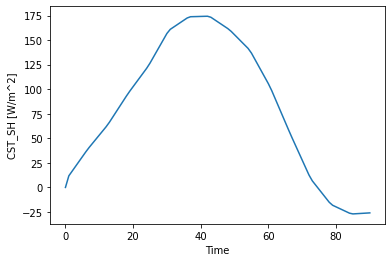

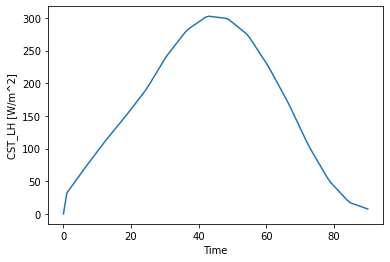

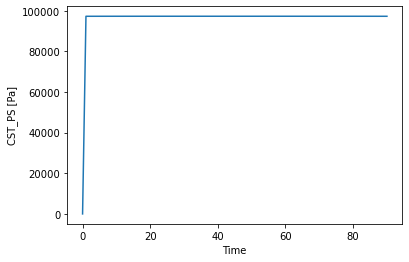

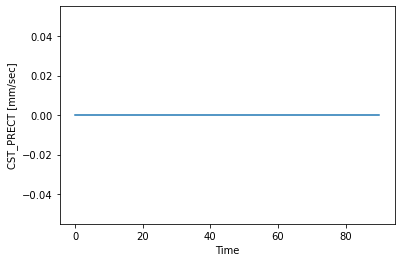

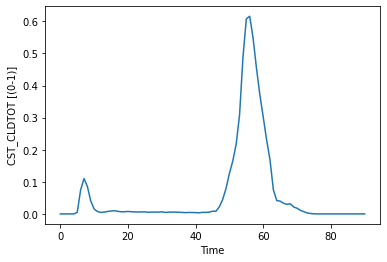

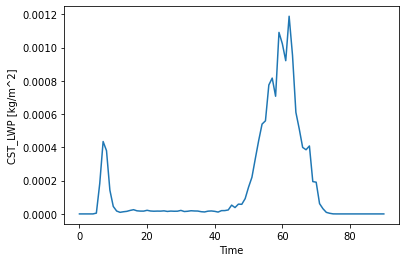

In [27]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat2_d01_2019-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

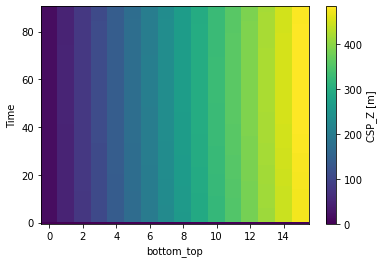

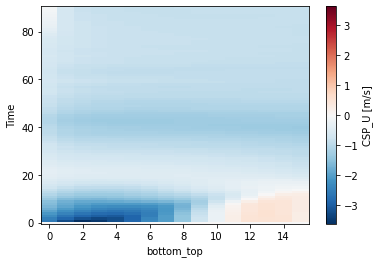

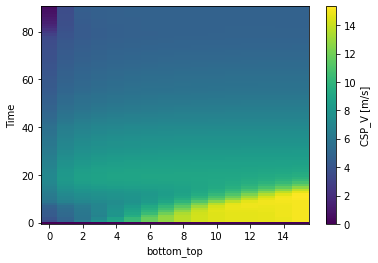

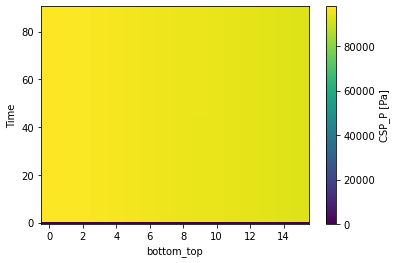

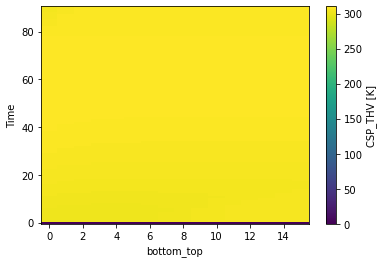

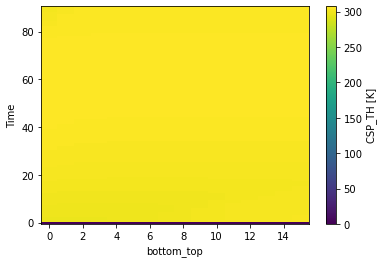

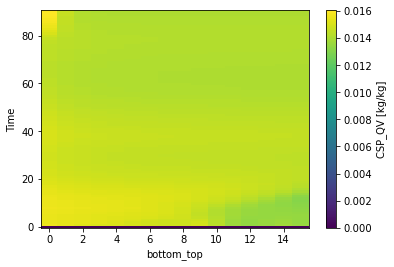

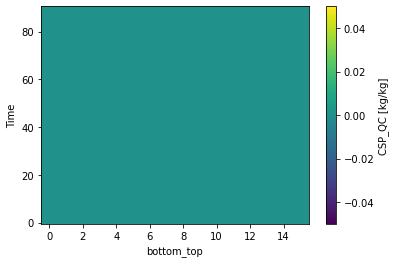

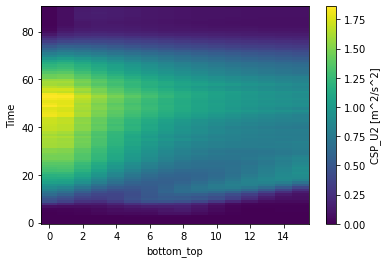

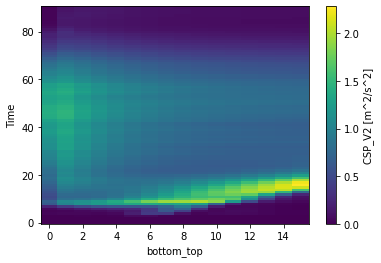

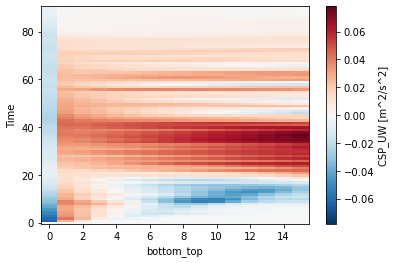

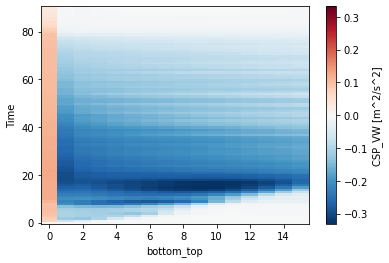

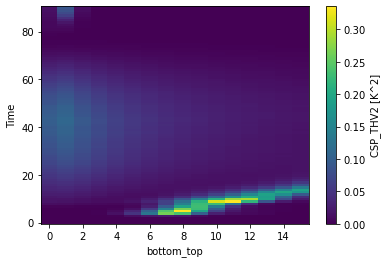

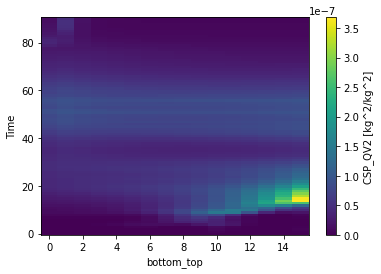

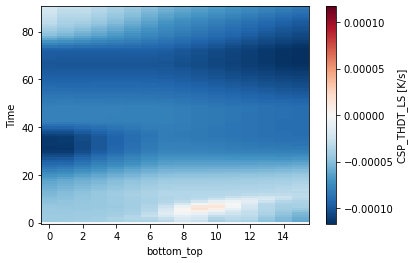

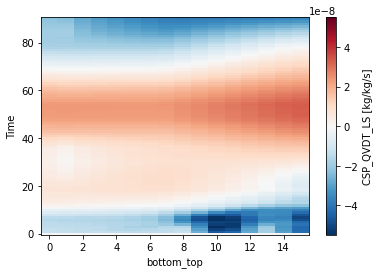

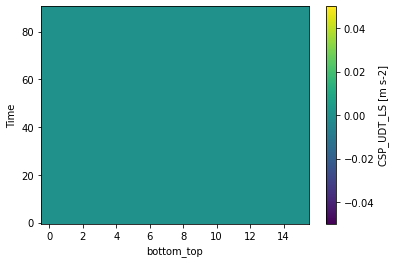

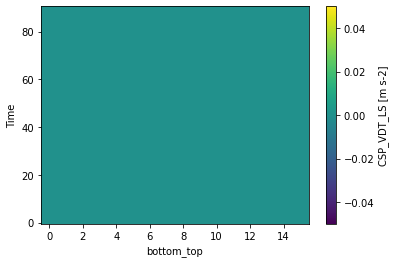

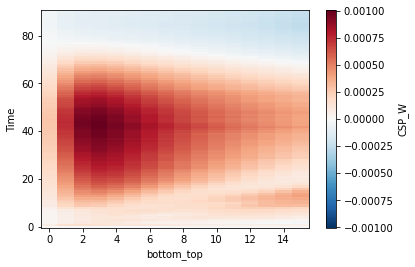

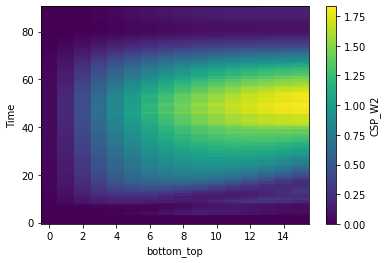

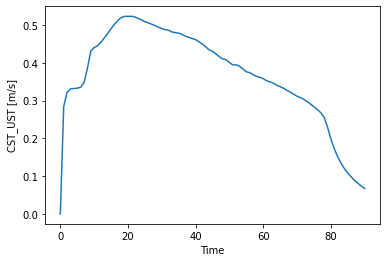

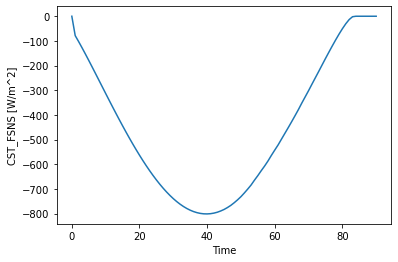

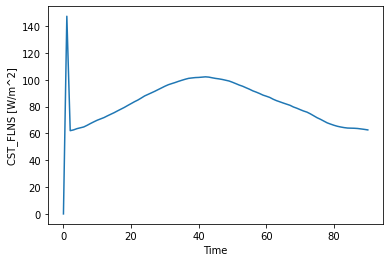

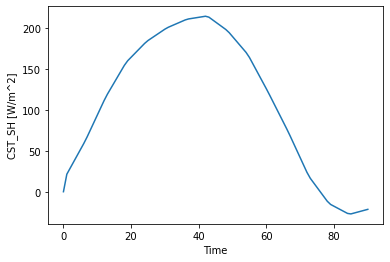

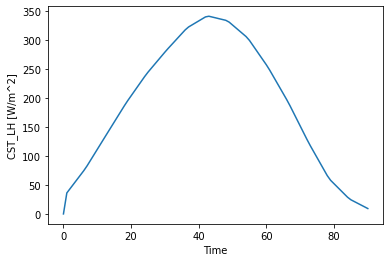

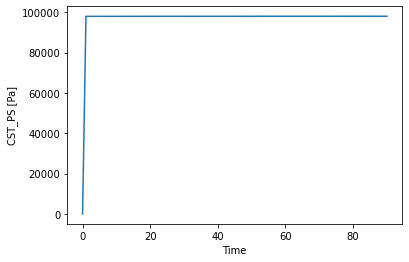

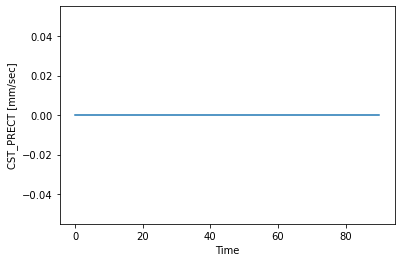

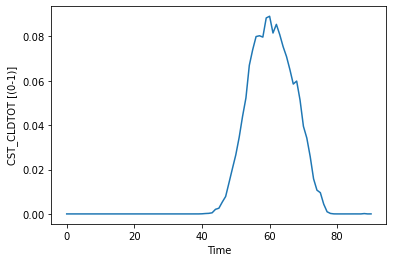

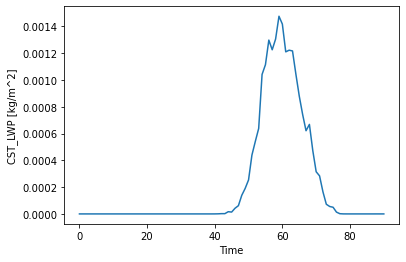

In [28]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat2_d01_2018-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

In [62]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat1_d01_2019-07-04_12:00:00.nc')

In [63]:
test['XLAT'].values.squeeze().shape

(91, 250, 250)

1545772

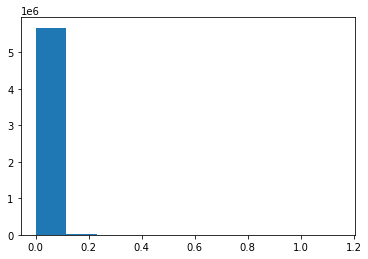

In [64]:
plt.hist(test['XLAT'].values.flatten())
(test['XLAT'].values.flatten() != 0).sum()

(array([5.681566e+06, 4.301000e+03, 9.670000e+02, 3.310000e+02,
        1.850000e+02, 6.600000e+01, 4.400000e+01, 2.400000e+01,
        1.100000e+01, 5.000000e+00]),
 array([0.        , 0.00236877, 0.00473753, 0.0071063 , 0.00947507,
        0.01184384, 0.0142126 , 0.01658137, 0.01895014, 0.0213189 ,
        0.02368767], dtype=float32),
 <BarContainer object of 10 artists>)

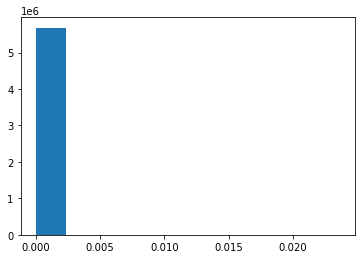

In [57]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat1_d01_2018-07-04_12:00:00.nc')
plt.hist(test['XLAT'].values.flatten())

In [61]:
(test['XLAT'].values.flatten() != 0).sum()

94547

In [65]:
test

<xarray.Dataset>
Dimensions:      (Time: 91, bottom_top: 16, south_north: 250, west_east: 250)
Coordinates:
    XLAT         (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    XLONG        (Time, south_north, west_east) float32 ...
    XTIME        (Time) datetime64[ns] ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Data variables:
    CSP_Z        (Time, bottom_top) float32 ...
    CSP_U        (Time, bottom_top) float32 ...
    CSP_V        (Time, bottom_top) float32 ...
    CSP_P        (Time, bottom_top) float32 ...
    CSP_THV      (Time, bottom_top) float32 ...
    CSP_TH       (Time, bottom_top) float32 ...
    CSP_QV       (Time, bottom_top) float32 ...
    CSP_QC       (Time, bottom_top) float32 ...
    CSP_U2       (Time, bottom_top) float32 ...
    CSP_V2       (Time, bottom_top) float32 ...
    CSP_UW       (Time, bottom_top) float32 ...
    CSP_VW       (Time, bottom_top) float32 ...
    CSP_THV2     (Time, bottom_top) float32 ...
    CSP_QV2      (Time, bottom_top) float32 ...
    CSP_THDT_LS  (Time, bottom_top) float32 ...
    CSP_QVDT_LS  (Time, bottom_top) float32 ...
    CSP_UDT_LS   (Time, bottom_top) float32 ...
    CSP_VDT_LS   (Time, bottom_top) float32 ...
    CSP_W        (Time, bottom_top) float32 ...
    CSP_W2       (Time, bottom_top) float32 ...
    CST_UST      (Time) float32 ...
    CST_FSNS     (Time) float32 ...
    CST_FLNS     (Time) float32 ...
    CST_SH       (Time) float32 ...
    CST_LH       (Time) float32 ...
    CST_PS       (Time) float32 ...
    CST_PRECT    (Time) float32 ...
    CST_CLDTOT   (Time) float32 ...
    CST_LWP      (Time) float32 ...
    Times        (Time) |S19 ...
Attributes:
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-07-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    DY:                                    100.0
    GRIDTYPE:                              C
    DIFF_OPT:                              2
    KM_OPT:                                2
    DAMP_OPT:                              3
    DAMPCOEF:                              0.2
    KHDIF:                                 1.0
    KVDIF:                                 1.0
    MP_PHYSICS:                            8
    RA_LW_PHYSICS:                         4
    RA_SW_PHYSICS:                         4
    SF_SFCLAY_PHYSICS:                     1
    SF_SURFACE_PHYSICS:                    1
    BL_PBL_PHYSICS:                        0
    CU_PHYSICS:                            0
    SF_LAKE_PHYSICS:                       0
    SURFACE_INPUT_SOURCE:                  3
    SST_UPDATE:                            0
    GRID_FDDA:                             0
    GFDDA_INTERVAL_M:                      0
    GFDDA_END_H:                           0
    GRID_SFDDA:                            0
    SGFDDA_INTERVAL_M:                     0
    SGFDDA_END_H:                          0
    HYPSOMETRIC_OPT:                       1
    USE_THETA_M:                           1
    WEST-EAST_PATCH_START_UNSTAG:          1
    WEST-EAST_PATCH_END_UNSTAG:            250
    WEST-EAST_PATCH_START_STAG:            1
    WEST-EAST_PATCH_END_STAG:              251
    SOUTH-NORTH_PATCH_START_UNSTAG:        1
    SOUTH-NORTH_PATCH_END_UNSTAG:          250
    SOUTH-NORTH_PATCH_START_STAG:          1
    SOUTH-NORTH_PATCH_END_STAG:            251
    BOTTOM-TOP_PATCH_START_UNSTAG:         1
    BOTTOM-TOP_PATCH_END_UNSTAG:           226
    BOTTOM-TOP_PATCH_START_STAG:           1
    BOTTOM-TOP_PATCH_END_STAG:             227
    GRID_ID:                               1
    PARENT_ID:                             0
    I_PARENT_START:                        0
    J_PARENT_START:                        0
    PARENT_GRID_RATIO:                     1
    DT: 